In [1]:
using DataFrames, Gadfly, RCall

INFO: Precompiling module Gadfly.


In [2]:
wiener(n) = DataFrame(t = 1:n, y = cumsum(randn(n)))  # discrete time Wiener process

wiener (generic function with 1 method)

In [3]:
wiener(10)   # first call causes compilation

,t,y
1,1,-0.572124852684274
2,2,-0.1385439559127256
3,3,0.552091644358092
4,4,0.09480867679225213
5,5,-0.1091460159455706
6,6,0.4747149228919779
7,7,1.4622507718202247
8,8,0.15378711476572693
9,9,-0.06798763692609133
10,10,-0.4833792968755524


In [4]:
@time w = wiener(100000)

  0.003366 seconds (125 allocations: 2.321 MiB)


,t,y
1,1,-1.3682073826030774
2,2,-2.9022384279280824
3,3,-1.2826042125864963
4,4,-3.459347175419569
5,5,-2.9947785167521612
6,6,-2.8435770249676917
7,7,-1.5724885882814157
8,8,-2.190407803909686
9,9,-2.69470737295271
10,10,-2.2437436904878836


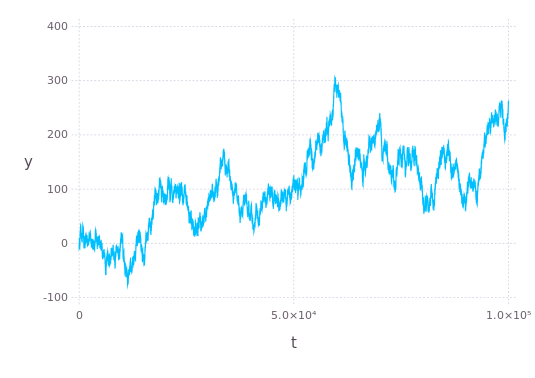

In [5]:
plot(w, x = :t, y = :y, Geom.line)

Technically, there should be a value of 0 at time zero.

In [6]:
wiener(n) = DataFrame([0:n, unshift!(cumsum(randn(n)), 0)], [:t, :y])

wiener (generic function with 1 method)

In [7]:
wiener(10)

,t,y
1,0,0.0
2,1,0.6922498916973779
3,2,0.5566165749817387
4,3,2.4675896453865906
5,4,2.127769018101945
6,5,1.2619060091747825
7,6,1.3846507031008128
8,7,0.9365747903147013
9,8,0.5783990542169473
10,9,3.270126773207214


For reproducibility, we should set the random number generator seed

In [8]:
srand(1234321)
@time w = wiener(100000)

  0.003990 seconds (32 allocations: 2.291 MiB)


,t,y
1,0,0.0
2,1,-0.16076694657032825
3,2,-1.6435175937458977
4,3,-2.027936323201796
5,4,-3.3820412483932496
6,5,-2.343620992160594
7,6,-3.5063006894866757
8,7,-3.526555440358628
9,8,-4.274118082572377
10,9,-2.9501809052569556


Setting the random number generator seed changes global state.  We can set the state by passing a random number generator to the function.

In [9]:
wiener(rng::AbstractRNG, n) = DataFrame([0:n, unshift!(cumsum(randn(rng, n)), 0)], [:t, :y])    

wiener (generic function with 2 methods)

In [10]:
wiener(MersenneTwister(1234321), 30)

,t,y
1,0,0.0
2,1,-0.16076694657032825
3,2,-1.6435175937458977
4,3,-2.027936323201796
5,4,-3.3820412483932496
6,5,-2.343620992160594
7,6,-3.5063006894866757
8,7,-3.526555440358628
9,8,-4.274118082572377
10,9,-2.9501809052569556


The default method, using the global RNG can then be defined in terms of this method.

In [11]:
wiener(n) = wiener(Base.Random.GLOBAL_RNG, n)

wiener (generic function with 2 methods)

In [13]:
methods(wiener)

# 2 methods for generic function "wiener":
wiener(rng::AbstractRNG, n) in Main at In[9]:1
wiener(n) in Main at In[11]:1

In [14]:
srand(1234321)
wiener(10)

,t,y
1,0,0.0
2,1,-0.16076694657032825
3,2,-1.6435175937458977
4,3,-2.027936323201796
5,4,-3.3820412483932496
6,5,-2.343620992160594
7,6,-3.5063006894866757
8,7,-3.526555440358628
9,8,-4.274118082572377
10,9,-2.9501809052569556


## Alternative implementations

Unlike R, Matlab, etc., there is no inherent penalty on looping in Julia.

In [15]:
function wiener(rng::AbstractRNG, n)
    s = randn(rng)
    y = zeros(typeof(s), n + 1)
    for i in 1:n
        y[i + 1] = s
        s += randn(rng)
    end
    DataFrame([0:n, y], [:t, :y])
end

wiener (generic function with 2 methods)

In [16]:
wiener(MersenneTwister(1234321), 10)

,t,y
1,0,0.0
2,1,-0.16076694657032825
3,2,-1.6435175937458977
4,3,-2.027936323201796
5,4,-3.38204124839325
6,5,-2.3436209921605946
7,6,-3.506300689486676
8,7,-3.5265554403586283
9,8,-4.274118082572377
10,9,-2.950180905256956


In [17]:
@time w = wiener(MersenneTwister(1234321), 100_000)

  0.001488 seconds (37 allocations: 789.938 KiB)


,t,y
1,0,0.0
2,1,-0.16076694657032825
3,2,-1.6435175937458977
4,3,-2.027936323201796
5,4,-3.38204124839325
6,5,-2.3436209921605946
7,6,-3.506300689486676
8,7,-3.5265554403586283
9,8,-4.274118082572377
10,9,-2.950180905256956


We can even use the naive approach of starting with an empty vector and appending to it in a loop.

In [18]:
function wiener(rng::AbstractRNG, n)
    s = randn(rng)
    y = [zero(s), s]   # first two elements
    for i in 1:(n - 1)
        s += randn(rng)
        push!(y, s)
    end
    DataFrame([0:n, y], [:t, :y])
end

wiener (generic function with 2 methods)

In [19]:
wiener(MersenneTwister(1234321), 10)

,t,y
1,0,0.0
2,1,-0.16076694657032825
3,2,-1.6435175937458977
4,3,-2.027936323201796
5,4,-3.38204124839325
6,5,-2.3436209921605946
7,6,-3.506300689486676
8,7,-3.5265554403586283
9,8,-4.274118082572377
10,9,-2.950180905256956


In [20]:
@time w = wiener(MersenneTwister(1234321), 100_000)

  0.002897 seconds (53 allocations: 2.009 MiB)


,t,y
1,0,0.0
2,1,-0.16076694657032825
3,2,-1.6435175937458977
4,3,-2.027936323201796
5,4,-3.38204124839325
6,5,-2.3436209921605946
7,6,-3.506300689486676
8,7,-3.5265554403586283
9,8,-4.274118082572377
10,9,-2.950180905256956


This is slightly slower but not drastically slower than pre-allocating.  If we know the approximate size of the result, we can give a hint.

In [21]:
function wiener(rng::AbstractRNG, n)
    s = randn(rng)
    y = sizehint!([zero(s)], n+1)
    for i in 1:n
        push!(y, s)
        s += randn(rng)
    end
    DataFrame([0:n, y], [:t, :y])
end

wiener (generic function with 2 methods)

In [22]:
wiener(MersenneTwister(1234321), 10)

,t,y
1,0,0.0
2,1,-0.16076694657032825
3,2,-1.6435175937458977
4,3,-2.027936323201796
5,4,-3.38204124839325
6,5,-2.3436209921605946
7,6,-3.506300689486676
8,7,-3.5265554403586283
9,8,-4.274118082572377
10,9,-2.950180905256956


In [23]:
@time w = wiener(MersenneTwister(1234321), 100_000)

  0.003475 seconds (37 allocations: 1.008 MiB)


,t,y
1,0,0.0
2,1,-0.16076694657032825
3,2,-1.6435175937458977
4,3,-2.027936323201796
5,4,-3.38204124839325
6,5,-2.3436209921605946
7,6,-3.506300689486676
8,7,-3.5265554403586283
9,8,-4.274118082572377
10,9,-2.950180905256956


In [24]:
using BenchmarkTools

INFO: Recompiling stale cache file /home/bates/.julia/lib/v0.6/JLD.ji for module JLD.


In [28]:
@btime wiener(MersenneTwister(1234321), 100_000)  seconds=1;

  1.408 ms (33 allocations: 1.01 MiB)
